In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
from collections import Counter
import numpy as np
from collections import defaultdict
import h3

In [2]:
from toolbox import *

In [3]:
%matplotlib inline

In [4]:
year=2020
dates=[{'month': 1, 'day': d} for d in range(1, 32)] + [
    {'month': 2, 'day': d} for d in range(1, 13)]

In [13]:
all_persons_summary=get_person_summaries(year, dates)

Couldn't get data for 2020_2_13


In [ ]:
residents=pd.read_csv('../outputs/days_present/presence_others.csv', usecols=[0])

In [23]:
residents_imsis=set(residents['Unnamed: 0'].values)

In [25]:
for imsi in all_persons_summary:
    if imsi in residents_imsis:
        all_persons_summary[imsi]['status']='resident'
    else:
        all_persons_summary[imsi]['status']='tourist'

Categorise by the most common nationalities or Other

In [26]:
mcc_dict={204: 'Dutch', 213:'Andorran',214:'Spanish', 208:'French',234:'British'}

In [27]:
for imsi in all_persons_summary:
    try:
        all_persons_summary[imsi]['nation']= mcc_dict[all_persons_summary[imsi]['mcc']]
    except:
        all_persons_summary[imsi]['nation']='Other'      

### Load home locations from file

In [39]:
jan_homes=pd.read_csv('../outputs/homes/2020_1_homes.csv')
feb_homes=pd.read_csv('../outputs/homes/2020_2_homes.csv')

jan_homes=jan_homes.set_index('imsi')
feb_homes=feb_homes.set_index('imsi')

In [41]:
all_imsi_jan_homes=set(jan_homes.index)
all_imsi_feb_homes=set(feb_homes.index)

In [ ]:
for i_p, imsi in enumerate(all_persons_summary):
    if i_p%10000==0:
        print(i_p)
    if imsi in all_imsi_jan_homes:
        all_persons_summary[imsi]['home_parish']=jan_homes.loc[imsi, 'parish']
        all_persons_summary[imsi]['nights']=jan_homes.loc[imsi, 'nights']
    elif imsi in all_imsi_feb_homes:
        all_persons_summary[imsi]['home_parish']=feb_homes.loc[imsi, 'parish']
        all_persons_summary[imsi]['nights']=feb_homes.loc[imsi, 'nights']
    else:
        all_persons_summary[imsi]['home_parish']=None
        all_persons_summary[imsi]['status']=None # person with no stay data- should be excluded

In [43]:
ct_nation_status=pd.crosstab(pd.Series([all_persons_summary[p]['status'] for p in all_persons_summary]),
                         pd.Series([all_persons_summary[p]['nation'] for p in all_persons_summary]),
                         normalize=0)

### Check the MCC against the status to make sure the results are reasonable

In [44]:
ct_nation_status

col_0,Andorran,British,Dutch,French,Other,Spanish
row_0,,,,,,
resident,0.871939,0.003009,0.024668,0.035153,0.023435,0.041796
tourist,0.040607,0.073350,0.033562,0.178446,0.186475,0.487560


Check the distributions of home parishes among residents, temps and tourists

In [46]:
ct_home_status=pd.crosstab(pd.Series([all_persons_summary[p]['status'] for p in all_persons_summary]),
                         pd.Series([all_persons_summary[p]['home_parish'] for p in all_persons_summary]),
                         normalize=False)
ct_home_status

col_0,Andorra la Vella,Canillo,Encamp,Escaldes-Engordany,La Massana,Ordino,Sant Julià de Lòria
row_0,,,,,,,
resident,22201,6557,7966,8269,8218,3144,6115
tourist,31633,75810,11294,17362,21044,7173,4178


Check the distributions of home parishes among different nationalities of tourists

In [49]:
ct_home_status=pd.crosstab(pd.Series([all_persons_summary[p]['home_parish'] for p in all_persons_summary if all_persons_summary[p]['status']=='tourist']),
                         pd.Series([all_persons_summary[p]['nation'] for p in all_persons_summary if all_persons_summary[p]['status']=='tourist']),
                         normalize=False)
ct_home_status

col_0,Andorran,British,Dutch,French,Other,Spanish
row_0,,,,,,
Andorra la Vella,2179,424,1391,4773,5501,17365
Canillo,1567,8470,2310,16608,14668,32187
Encamp,655,259,365,1696,3155,5164
Escaldes-Engordany,756,305,646,2406,2758,10491
La Massana,826,2705,560,2832,4327,9794
Ordino,324,131,205,1375,525,4613
Sant Julià de Lòria,535,65,178,377,486,2537


In [51]:
all_tourist_home_parishes=ct_home_status.sum(axis=1)
print(all_tourist_home_parishes)
prop_Canillo=all_tourist_home_parishes['Canillo']/all_tourist_home_parishes.sum()
prop_Canillo

row_0
Andorra la Vella       31633
Canillo                75810
Encamp                 11294
Escaldes-Engordany     17362
La Massana             21044
Ordino                  7173
Sant Julià de Lòria     4178
dtype: int64


0.4499270003679656

### Show arrivals of tourists over time by residence parish and nationality

In [60]:
nation_cats=[mcc_dict[mcc] for mcc in mcc_dict]+['Other']
parish_cats=[parish for parish in parish_names_list]+['Unknown/None']
arrivals_by_parish_by_day=n_people_present_by_mcc_day={parish: [0 for i in range(len(dates))] for parish in parish_cats}
arrivals_by_nation_by_day=n_people_present_by_mcc_day={nation: [0 for i in range(len(dates))] for nation in nation_cats}

for imsi in all_persons_summary:
    if all_persons_summary[imsi]['status']=='tourist':
        home_parish=all_persons_summary[imsi]['home_parish']
        if home_parish == None:
            home_parish='Unknown/None'
        arrival_day=all_persons_summary[imsi]['first']
        nation=all_persons_summary[imsi]['nation']
        arrivals_by_parish_by_day[home_parish][arrival_day]+=1
        arrivals_by_nation_by_day[nation][arrival_day]+=1     

### Plot arrivals by nation

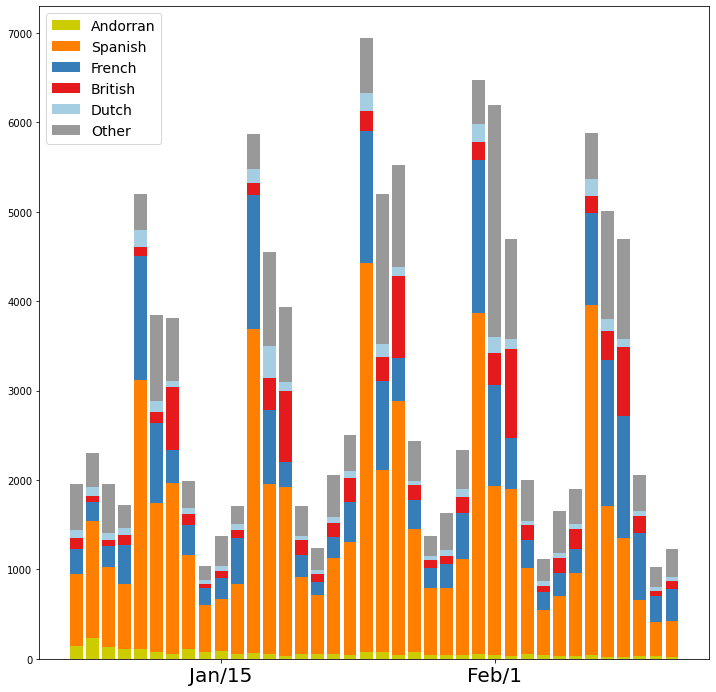

In [61]:
fig=plt.figure(figsize=(12,12))

burn_in=5
burn_out=1

an=arrivals_by_nation_by_day['Andorran'][burn_in:-burn_out]
sp=arrivals_by_nation_by_day['Spanish'][burn_in:-burn_out]
fr=arrivals_by_nation_by_day['French'][burn_in:-burn_out]
br=arrivals_by_nation_by_day['British'][burn_in:-burn_out]
dt=arrivals_by_nation_by_day['Dutch'][burn_in:-burn_out]
ot=arrivals_by_nation_by_day['Other'][burn_in:-burn_out]

totals=np.array([0 for i in range(len(an))])
p_an = plt.bar(range(len(an)), an, 
             bottom=totals,color='#cccc00', align='center')
totals+=np.array(an)

p_sp = plt.bar(range(len(sp)), sp, 
             bottom=totals,color='#ff7f00', align='center')
totals+=np.array(sp)

p_fr = plt.bar(range(len(fr)), fr, bottom=totals, color='#377eb8', align='center')
totals+=np.array(fr)

p_br = plt.bar(range(len(br)), br, bottom=totals, color='#e41a1c', align='center')
totals+=np.array(br)

p_dt = plt.bar(range(len(dt)), dt, bottom=totals, color='#a6cee3', align='center')
totals+=np.array(dt)

p_ot = plt.bar(range(len(ot)), ot,
             bottom=totals, color='#999999', align='center')

date_strs=['{}_{}'.format(date['month'], date['day']) for date in dates[burn_in:-burn_out]]
x_tick_locs=[date_strs.index('1_15'), date_strs.index('2_1')]
x_tick_labels=['Jan/15', 'Feb/1']
plt.xticks(ticks=x_tick_locs, 
           labels=x_tick_labels, fontsize=20)


leg=plt.legend((p_an[0], p_sp[0], p_fr[0],p_br[0], p_dt[0], p_ot[0]), ('Andorran', 'Spanish', 'French', 'British', 'Dutch','Other'), fontsize=15, prop={'size': 14})
for text in leg.get_texts():
    plt.setp(text, color = 'k')
plt.savefig('tourist_arrivals_by_nation.png')
    

### Plot arrivals of tourists by parish where they stay

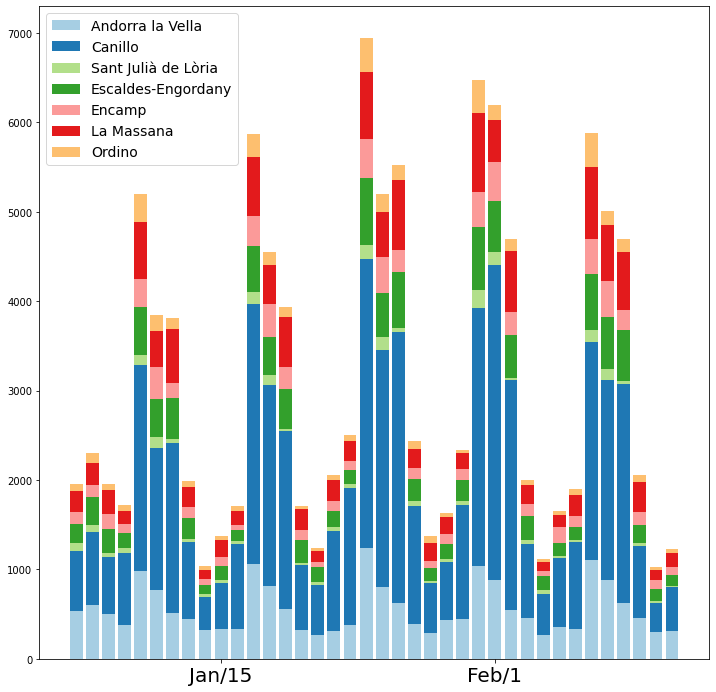

In [62]:
fig=plt.figure(figsize=(12,12))
# fig.set_facecolor('black')

burn_in=5
burn_out=1

n_days=len(dates[burn_in:-burn_out])
colors=['#a6cee3',
'#1f78b4',
'#b2df8a',
'#33a02c',
'#fb9a99',
'#e31a1c',
'#fdbf6f',
'#ff7f00']

bars_list, parish_list=[], []
totals=np.array([0 for i in range(n_days)])
for i_p, parish in enumerate(parish_cats):
    if not parish =='Unknown/None':
        new_values=arrivals_by_parish_by_day[parish][burn_in:-burn_out]
        new_bars = plt.bar(range(n_days), new_values, 
                     bottom=totals,color=colors[i_p], align='center')
        bars_list.append(new_bars)
        parish_list.append(parish)
        totals+=np.array(new_values)

date_strs=['{}_{}'.format(date['month'], date['day']) for date in dates[burn_in:-burn_out]]
x_tick_locs=[date_strs.index('1_15'), date_strs.index('2_1')]
x_tick_labels=['Jan/15', 'Feb/1']
plt.xticks(ticks=x_tick_locs, 
           labels=x_tick_labels, fontsize=20)

leg=plt.legend(bars_list, parish_list, fontsize=15, prop={'size': 14})
for text in leg.get_texts():
    plt.setp(text, color = 'k')
plt.savefig('tourist_arrivals_by_parish.png')

### Create an adjacency matrix to represent quantity of interactions between 10 compartments:
#### 1 compartment for each of 7 parishes (temp and resi) and French, Spanish, Other tourists

#### Load the indoor/outdoor data for h3 cells so we can categorise interactions

In [65]:
person_cats=[parish for parish in parish_names_list]+['French', 'Spanish', 'Other']

In [66]:
building_cover_all_cells=json.load(open('../outputs/h3_res11_builtup.json'))

Iterate through days of data, find the h3 cell of every stay in each period<br>
For every "co-located" pair of stays, add 1 to the adjacency matrix

In [67]:
intervals, T=create_intervals(interval_length_minutes=10)
resolution=11

In [68]:
def get_h3_cells_person_cats_by_interval(resolution, intervals, T, persons):
    # iterate through all stays and get the interval and the h3 cell
    stay_ind_by_interval=[[] for i in range(len(intervals))]
    cell_ids_by_stay_ind=[]
    cat_by_stay_ind=[]
    cats_by_person=[]
    for person in persons:
        # first establish the person category
        imsi=person['imsi']
        home_parish=all_persons_summary[imsi]['home_parish']
        nation=all_persons_summary[imsi]['nation']
        status=all_persons_summary[imsi]['status']
        if status in ['temp', 'resident']:
            cat=home_parish
        else:
            if nation not in ['Spanish', 'French']:
                nation='Other'
            cat=nation
        cats_by_person.append(cat)
        # then find the h3 cell of every stay
        for stay in person['stay_points']:
            int_start=int(stay['s']/T)
            int_end=int(stay['e']/T)
            for int_id in range(int_start, int_end+1):
                stay_ind_by_interval[int_id].append(len(cell_ids_by_stay_ind))  
            cell_id=h3.geo_to_h3(stay['p'][1], stay['p'][0], resolution=resolution)
            cell_ids_by_stay_ind.append(cell_id)
            cat_by_stay_ind.append(cat)
    return stay_ind_by_interval, cell_ids_by_stay_ind, cat_by_stay_ind, Counter(cats_by_person)

In [71]:
def get_adj_mat_one_day(stay_ind_by_interval, cell_ids_by_stay_ind, cat_by_stay_ind, return_indoor=False):
    adj_mat_day=np.zeros([len(person_cats), len(person_cats)])
    if return_indoor:
        adj_mat_day_indoor=np.zeros([len(person_cats), len(person_cats)])
    for s_ind_this_interval in stay_ind_by_interval:
        cats_this_interval_by_cell={}
        # for every grid cell in this interval, find the mix of people who were there
        for s_ind in s_ind_this_interval:
            cell_id=cell_ids_by_stay_ind[s_ind]
            cat=cat_by_stay_ind[s_ind]
            if cell_id not in cats_this_interval_by_cell:
                cats_this_interval_by_cell[cell_id]=defaultdict(int)
            cats_this_interval_by_cell[cell_id][cat]+=1
        # iterate through each cell and fid the category interactions
        for cell_id in cats_this_interval_by_cell:
            try:
                indoor=building_cover_all_cells[cell_id]
            except:
                indoor=0
            for i_cat in range(len(person_cats)):
                i_cat_name=person_cats[i_cat]
                if cats_this_interval_by_cell[cell_id][i_cat_name]>0:
                    adj_mat_day[i_cat, i_cat]+=(cats_this_interval_by_cell[cell_id][i_cat_name])**2-1
                for j_cat in range(i_cat+1, len(person_cats)):
                    j_cat_name=person_cats[j_cat]
                    interactions=(cats_this_interval_by_cell[cell_id][i_cat_name])*(
                        cats_this_interval_by_cell[cell_id][j_cat_name]) 
                    adj_mat_day[i_cat, j_cat]+=interactions
                    adj_mat_day[j_cat, i_cat]+=interactions
                    if ((indoor==1) and (return_indoor)):
                        adj_mat_day_indoor[i_cat, j_cat]+=interactions
                        adj_mat_day_indoor[j_cat, i_cat]+=interactions
    if return_indoor:
        return adj_mat_day, adj_mat_day_indoor
    return adj_mat_day

For this step only use the February data as we're intersted in behaviour just before the start of infections

In [82]:
feb_dates=dates=[{'month': 2, 'day': d} for d in range(1, 13)]

In [ ]:
all_per_person_adj_mats=[]
all_per_person_adj_mats_indoor=[]
for date in feb_dates:
    month=date['month']
    day=date['day']
    print('{}_{}'.format(month, day))
    persons=json.load(open('../data/private/stays/{}_{}/stays_{}_{}_{}.json'.format(year, month, year, month, day)))  
    stay_ind_by_interval, cell_ids_by_stay_ind, cat_by_stay_ind, cat_counts=get_h3_cells_person_cats_by_interval(
        resolution, intervals, T, persons)
    adj_mat_day, adj_mat_day_indoor=get_adj_mat_one_day(stay_ind_by_interval, cell_ids_by_stay_ind, cat_by_stay_ind,
                                                        return_indoor=True)
    pop_vector=np.array([cat_counts[cat] for cat in person_cats])[:, None]
    per_person_adj_mat=adj_mat_day/pop_vector
    per_person_adj_mat_indoor=adj_mat_day_indoor/pop_vector
#     all_adj_mats.append(adj_mat_day)
    all_per_person_adj_mats.append(per_person_adj_mat)
    all_per_person_adj_mats_indoor.append(per_person_adj_mat_indoor)

In [66]:
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

In [84]:
avg_pp_adj_mat_indoor=np.average(all_per_person_adj_mats_indoor, axis=0)
avg_pp_adj_mat=np.average(all_per_person_adj_mats, axis=0)

In [85]:
labels=[c.replace('_', ' ') for c in person_cats]

In [86]:
pp_adj_mat_df=pd.DataFrame(avg_pp_adj_mat, columns=labels, index=labels)
pp_adj_mat_indoor_df=pd.DataFrame(avg_pp_adj_mat_indoor, columns=labels, index=labels)

In [68]:
order=sorted([parish for parish in parish_names_list])+['French', 'Spanish', 'Other']

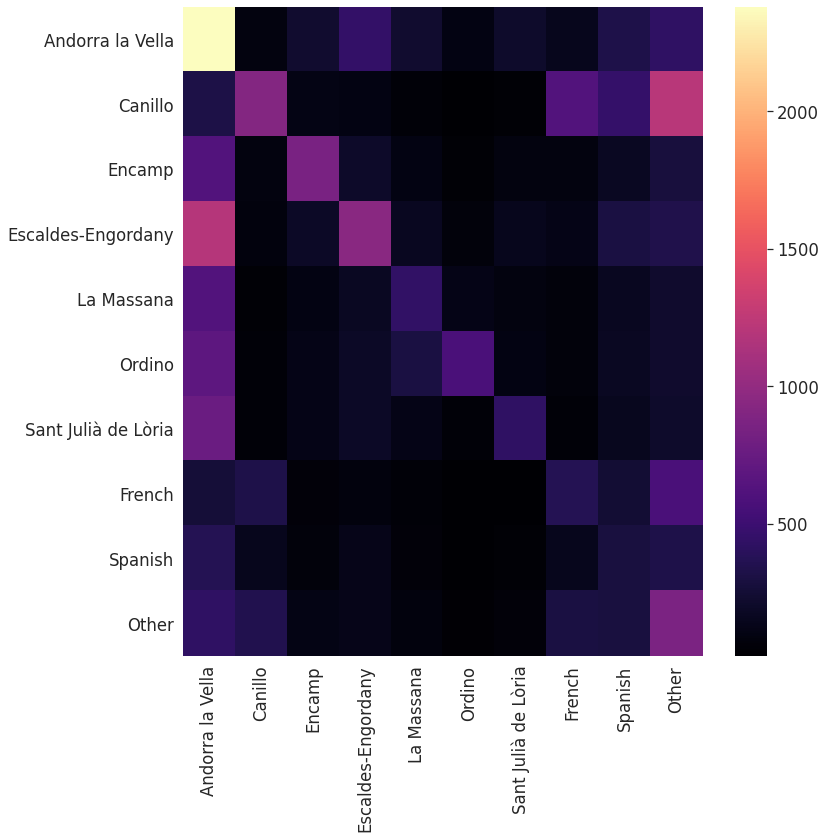

In [71]:
fig=plt.figure(figsize=(12, 12))
ax = sns.heatmap(pp_adj_mat_df.loc[order, order], cmap='magma')
fig.tight_layout()

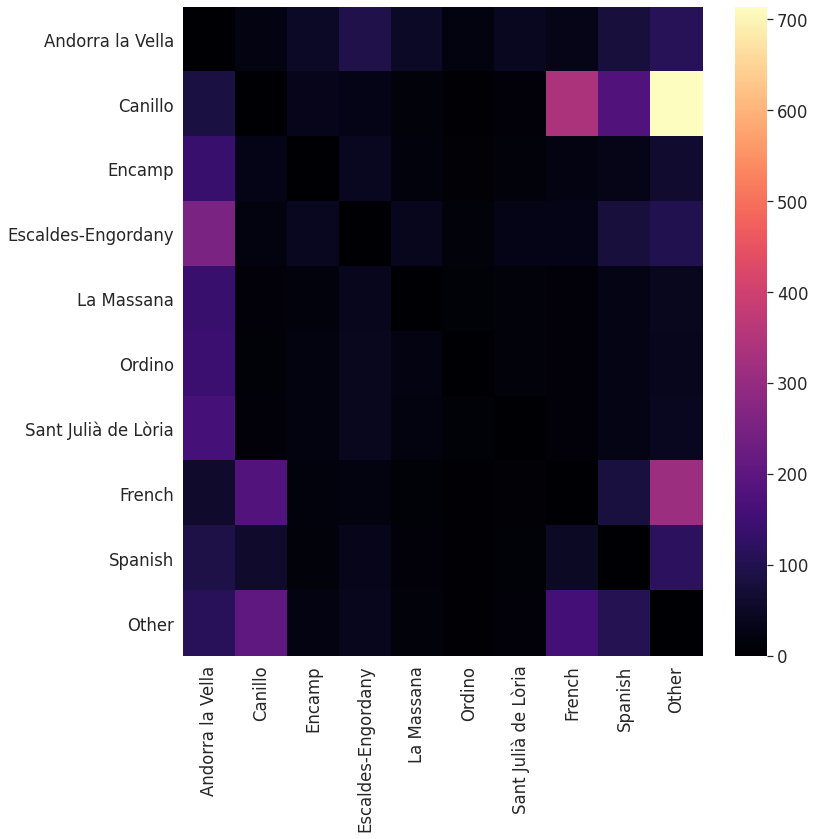

In [72]:
fig=plt.figure(figsize=(12, 12))
ax = sns.heatmap(pp_adj_mat_indoor_df.loc[order, order], cmap='magma')
fig.tight_layout()